## Final Project Submission

* Student name: Kiarash Ahmadi
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Jeff Herman 
* Blog post URL: 

# Introduction:

For this project, we are going to analyze the Northwind Database which is a fictional company created by Microsoft. From this database, we hope to gain insight in order to give advice to the stakeholders at the fictional company. This insight will be gained via statistical analysis in the form of hypothesis testing to answer the following questions:

**1. Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?**

**2. Does customer region have a statistically significant effect on the quantity and/or price of a product in an order?**

**3. Does the shipping company have a significant difference on the total price of an order?**

**4. Do specific categories have a higher average price? If so, is this difference statistically significant to conclude that categories have a statistically significant effect on the average price of an order?**

# Imports

First, import the necessary packages for this project.

In [2]:
import numpy as np
import pandas as pd
import sqlite3
from pandasql import sqldf
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [3]:
conn = sqlite3.connect("Northwind_small.sqlite")
cur = conn.cursor()
pysqldf = lambda q: sqldf(q, globals())

# Preliminary Exploratory Data Analysis

Let's have a better idea of the dataset that we are going to be hypothesis testing on by analyzing the different relationships the tables in this dataset have. This preliminary analysis combined with the schema helps to formulate the type of questions we'd like answered and to define the path one needs to take in order to successfully answer the questions. 

In [4]:
print('Number of Customers: {}'.format(cur.execute("""SELECT COUNT(*) FROM Customer;""").fetchall()[0][0]))
print('Number of Companies: {}'.format(cur.execute("""SELECT COUNT(*) FROM Supplier;""").fetchall()[0][0]))
print('Number of Products: {}'.format(cur.execute("""SELECT COUNT(*) FROM Product;""").fetchall()[0][0]))
print('Number of Categories: {}'.format(cur.execute("""SELECT COUNT(*) FROM Category;""").fetchall()[0][0]))
print('Number of Employee: {}'.format(cur.execute("""SELECT COUNT(*) FROM Employee;""").fetchall()[0][0]))
print('Number of Shippers: {}'.format(cur.execute("""SELECT COUNT(*) FROM Shipper;""").fetchall()[0][0]))
print('Number of Regions: {}'.format(cur.execute("""SELECT COUNT(*) FROM Region;""").fetchall()[0][0]))
print('Number of Territory: {}'.format(cur.execute("""SELECT COUNT(*) FROM Territory;""").fetchall()[0][0]))
print('Number of Orders: {}'.format(cur.execute("""SELECT COUNT(*) FROM [Order];""").fetchall()[0][0]))

Number of Customers: 91
Number of Companies: 29
Number of Products: 77
Number of Categories: 8
Number of Employee: 9
Number of Shippers: 3
Number of Regions: 4
Number of Territory: 53
Number of Orders: 830


<img src='https://raw.githubusercontent.com/learn-co-curriculum/dsc-mod-3-project/master/Northwind_ERD_updated.png'>

# Hypothesis Testing

### Question 1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

In order to answer this question, let's define the null ($H_{o}$) and alternative ($H_{a}$) hypothesis:

- $H_{o}$: Discount has no statistically significant effect on the quantity of a product in an order
- $H_{a}$: Discount has a statistically significant effect on the quantity of a product in an order

Next we'll define the threshold for this hypothesis test as $\alpha = 0.05$. From there, we can now begin the process of testing this hypothesis. To do this first let's see what specific discounts have the most total quantity ordered

In [5]:
df_dis = pd.read_sql_query("""SELECT Discount * 100 AS Discount, SUM(Quantity) as 
                            Total_Quantity FROM Orderdetail GROUP BY Discount;""",conn)
df_dis

,Discount,Total_Quantity
0,0.0,28599
1,1.0,2
2,2.0,4
3,3.0,5
4,4.0,1
5,5.0,5182
6,6.0,2
7,10.0,4366
8,15.0,4456
9,20.0,4351


From this DataFrame, we can learn that the discounts that have the largest quantity are:
- 0% with a total of 28599 products ordered
- 5% with a total of 5182 products ordered
- 10% with a total of 4366 products ordered 
- 15% with a total of 4456 products ordered 
- 20% with a total of 4351 products ordered
- 25% with a total of 4339 products ordered

Thus, it would be prudent to focus on these 6 discount categories if/when we can reject the null hypothesis to where then the focus would be which levels of discount affect the quantity ordered the most. In the meantime let's focus on determining whether there is a significant effect between discount and quantity order. Thus to do that let's separate the data based on whether a discount was applied to an order or not and find if the sample size is large enough when evaluating the quantity per order for each ground (discount vs. no discount) as well as analyze the variance and mean of the samples.



In [6]:
df = pd.read_sql_query("""SELECT OrderId, Sum(Quantity) as quantity, 
                        Avg(Discount) as average_discount FROM OrderDetail
                            GROUP BY OrderId;""",conn)
df_no = df[df['average_discount'] == 0]
df_yes = df[df['average_discount'] > 0]
print('The average quantity ordered when a discount is not applied is: {}'.format(round(df_no.quantity.mean(),2)))
print('The average quantity ordered when a discount is applied is: {}'.format(round(df_yes.quantity.mean(),2)))
print('The variance of quanitity order when a discount is not applied is: {}'.format(round(np.var(df_no.quantity),2)))
print('The variance of quanitity order when a discount is applied is: {}'.format(round(np.var(df_yes.quantity),2)))
print('The sample size of the orders with no discount applied is {}'.format(len(df_no)))
print('The sample size of the orders with discount applied is {}'.format(len(df_yes)))

The average quantity ordered when a discount is not applied is: 52.44
The average quantity ordered when a discount is applied is: 72.94
The variance of quanitity order when a discount is not applied is: 2326.46
The variance of quanitity order when a discount is applied is: 2635.41
The sample size of the orders with no discount applied is 450
The sample size of the orders with discount applied is 380


In [7]:
stats.levene(df_yes.quantity, df_no.quantity, center='mean')

LeveneResult(statistic=1.0369358925445291, pvalue=0.30883261672605483)

This information is key in deciding which test to use as the number of samples seem to be over 30 but the two groups being compared have different sample sizes as well as different variances. Thus, a Welch-T-test seems appropriate. To confirm this, let's next observe the data's distribution to see if it is normal.

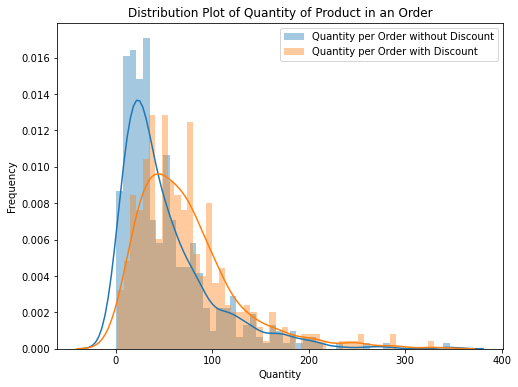

In [54]:
plt.figure(figsize = (8,6))
sns.distplot(df_no.quantity, bins = 50, label = 'Quantity per Order without Discount')
sns.distplot(df_yes.quantity, bins = 50, label = 'Quantity per Order with Discount')
plt.legend()
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.title('Distribution Plot of Quantity of Product in an Order')
plt.savefig('q1_dist.jpg')
plt.show()

From this distribution plot one can assume that the data is not normally distributed but to further confirm this point let's implement a Kolmogorov-Smirnov Test.

In [9]:
def ks_test(data):
    ks_statistic, p_value = stats.kstest(data, 'norm')
    if p_value >= 0.05:
        print('The data is normally distributed!')
    elif p_value < .05:
        print('The data is not normally distributed')

In [10]:
print('Is the sample of quantity per order with no discount normally distributed as defined by the K-S test? ')
ks_test(df_no.quantity)
print('Is the sample of quantity per order with discount normally distributed as defined by the K-S test? ')
ks_test(df_yes.quantity)

Is the sample of quantity per order with no discount normally distributed as defined by the K-S test? 
The data is not normally distributed
Is the sample of quantity per order with discount normally distributed as defined by the K-S test? 
The data is not normally distributed


From this we can see that indeed these two sets of data are not normally distributed but since the average sample size is greater than 30 we can move along and apply a Welch-t-test as seen below. 

In [11]:
def welch_t(a, b):
    
    """ Calculate Welch's t statistic for two samples. """
    
    numerator = a.mean() - b.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    t = np.abs(numerator/denominator)
    
    return t

def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. """
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    df = numerator/denominator
    
    return round(df, 0)
   
     #Return the degrees of freedom

def welch_t_p_value(a, b, two_sided=False):
    
    t = welch_t(a,b)
    df = welch_df(a,b)
    
    p = 1 - stats.t.cdf(t, df)
    
    if two_sided:
        return 2*p
    else:
        return p

In [12]:
welch_t_p_value(df_no.quantity, df_yes.quantity, two_sided = True)

5.850437467813663e-09

As we can see the test results in a p-value that is smaller than 0.05 and thus we can reject the null hypothesis. Let's now focus on the effect size of the samples by calculating Cohen's d. 

In [13]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [14]:
Cohen_d(df_yes.quantity, df_no.quantity)

0.4122521666326047

In [15]:
stats.levene(df_yes.quantity, df_no.quantity, center='mean')

LeveneResult(statistic=1.0369358925445291, pvalue=0.30883261672605483)

The effect size close the medium (0.5). Let's now assess the effect and subsequent significant difference of those discount categories we previously found. This helps to find which levels of discount have a significant difference and to what extent. Thus to do this let's first separate the data based on different discount levels. From there we will compare each discount level to samples that had no discount applied. 

In [34]:

df_dis = pd.read_sql_query("""SELECT ProductName, CAST (Discount * 100 AS INT) AS Discount, Quantity AS Quantity,
                        SUM(Quantity * OrderDetail.UnitPrice * (1 - Discount)) AS Price
                       FROM OrderDetail JOIN Product ON OrderDetail.ProductID = Product.ID
                       GROUP BY OrderID, ProductName
                       HAVING Discount IN (0, 0.05, 0.10, 0.15, 0.20, 0.25);""", conn)

df_dis.head(15)

,ProductName,Discount,Quantity,Price
0,Mozzarella di Giovanni,0,5,174.00
1,Queso Cabrales,0,12,168.00
2,Singaporean Hokkien Fried Mee,0,10,98.00
3,Manjimup Dried Apples,0,40,1696.00
4,Tofu,0,9,167.40
5,Jack's New England Clam Chowder,0,10,77.00
6,Louisiana Fiery Hot Pepper Sauce,15,15,214.20
7,Manjimup Dried Apples,15,35,1261.40
8,Gustaf's Knäckebröd,5,6,95.76
9,Louisiana Fiery Hot Pepper Sauce,0,20,336.00


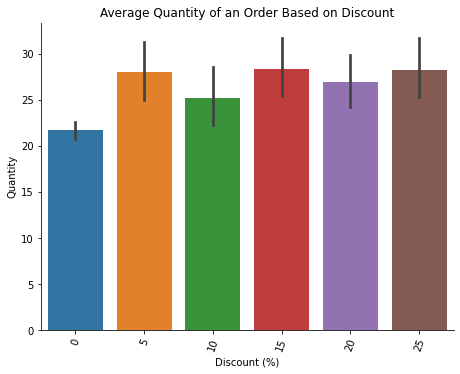

In [49]:
sns.catplot(x = 'Discount', y = 'Quantity', kind = 'bar', data = df_dis,height=5, aspect=1.3)
plt.xticks(rotation=70)
plt.title('Average Quantity of an Order Based on Discount')
plt.xlabel('Discount (%)')
plt.savefig('q1_quantity.jpg',bbox_inches='tight')
plt.show()

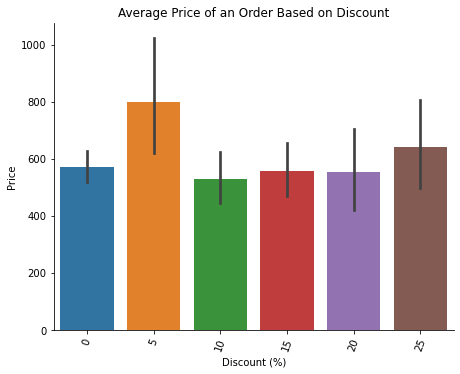

In [50]:
sns.catplot(x = 'Discount', y = 'Price', kind = 'bar', data = df_dis,height=5, aspect=1.3)
plt.xticks(rotation=70)
plt.title('Average Price of an Order Based on Discount')
plt.xlabel('Discount (%)')
plt.savefig('q1_price.jpg', bbox_inches='tight')
plt.show()

In [17]:
for discount in [5, 10, 15, 20, 25]:
    p = welch_t_p_value(df_dis[df_dis['Discount'] == 0].Quantity, df_dis[df_dis['Discount'] == discount].Quantity, two_sided = True)
    d = Cohen_d(df_dis[df_dis['Discount'] == 0].Quantity, df_dis[df_dis['Discount'] == discount].Quantity)
    print('The p_value using the Welch T-test for {}% discount is: {}'.format(discount,p))
    print("Cohen's d for {}% discount is: {}".format(discount,abs(d)))
    print('---------------------------------------------------------')

The p_value using the Welch T-test for 5% discount is: 0.00027243794492748385
Cohen's d for 5% discount is: 0.3468767736284547
---------------------------------------------------------
The p_value using the Welch T-test for 10% discount is: 0.037456123765644334
Cohen's d for 10% discount is: 0.19594203057834103
---------------------------------------------------------
The p_value using the Welch T-test for 15% discount is: 0.00017220075988877426
Cohen's d for 15% discount is: 0.3724041317472811
---------------------------------------------------------
The p_value using the Welch T-test for 20% discount is: 0.0008112569783553791
Cohen's d for 20% discount is: 0.3007122542913555
---------------------------------------------------------
The p_value using the Welch T-test for 25% discount is: 0.00015926484254569218
Cohen's d for 25% discount is: 0.3665925565267444
---------------------------------------------------------


From this, we see that every discount level has a significant difference on the quantity ordered. In addition the discount level that has the largest effect is 15% followed by 25%. Thus because of the fact that the two samples in question have different variances and sample size, a Welch T-test is used where $\alpha$ is set to 0.05. The resulting p-value when evaluating orders with discounts vs orders without was lower than the 0.05 threshold. Furthermore, each discount group with a large amount of quantity order was compared to orders with no discounts via a Welch T-test and the resulting p-values were also all under the threshold. Therefore one can reject the null hypothesis that discount does not have a statistically significant effect on the quantity of the product in an order. We can now transition to the next question that we will attempt to answer.


### Question 2: Does customer region have a statistically significant effect on the quantity of a product and/or the price in an order?

First, let's set up our hypotheses:

- $H_{o}$: Region has no statistically significant effect on the quantity or price of a product in an order
- $H_{a}$: Region has a statistically significant effect on the quantity or price of a product in an order

For now we will set $\alpha = 0.05$. To test this hypothesis, let's first examine how many regions there are and see if there are any interesting insights we can gain based on the total quantity or total price. Note that to calculate the total price the equation is as follows:

$$Total Price = Quantity * Unit Price * (1- Discount)$$



In [18]:
pd.read_sql_query("""SELECT Region, SUM(Quantity) as Total_Quantity,SUM(Quantity * UnitPrice * (1 - Discount)) AS Total_Price From customer
                    JOIN [Order] ON customer.id = [Order].CustomerID
                    JOIN OrderDetail ON [Order].id = Orderdetail.orderid
                    GROUP BY Region;""",conn)

,Region,Total_Quantity,Total_Price
0,British Isles,4426,108951.2150
1,Central America,666,16558.1000
2,Eastern Europe,205,3531.9500
3,North America,11314,295780.9005
4,Northern Europe,3405,87156.1625
5,Scandinavia,1046,24545.2025
6,South America,6359,142677.8080
7,Southern Europe,2073,45225.7175
8,Western Europe,20221,503548.4085


From this we can see that what the total quantity and total price ordered for each region. Thus in this case we want to compare multiple samples simultaneously, and thus in order to reduce the cumulative risk that comes about with this process, we are going to apply a Bonferroni correction to our threshold that is $\alpha$. This can be done by dividing alpha by the number of comparisons one is trying to make to get a new adjusted threshold. In our case this number of comparisons is 9 and thus the new threshold is: $\alpha_{adjusted} = 0.005556$. Let's now create a DataFrame that is ready to by tested.

In [19]:
df_reg = pd.read_sql_query("""SELECT Region, SUM(Quantity) as Total_Quantity,SUM(Quantity * UnitPrice * (1 - Discount)) AS Total_Price
                    From customer
                    JOIN [Order] ON customer.id = [Order].CustomerID
                    JOIN OrderDetail ON [Order].id = Orderdetail.orderid
                    GROUP BY orderid;""",conn)
df_reg.head()

,Region,Total_Quantity,Total_Price
0,Western Europe,27,440.00
1,Western Europe,49,1863.40
2,South America,60,1552.60
3,Western Europe,41,654.06
4,Western Europe,105,3597.90


We now have created the proper DataFrame to perform a hypothesis test. Due to the fact that this test requires multiple comparisons of 9 samples of data, an Analysis of Variance (ANOVA) is used.

In [20]:
formula = 'Total_Quantity ~ C(Region)'
lm = ols(formula, df_reg).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq     df         F        PR(>F)
C(Region)  1.835377e+05    8.0  9.494281  1.357462e-12
Residual   1.913808e+06  792.0       NaN           NaN


In [21]:
formula = 'Total_Price ~ C(Region)'
lm = ols(formula, df_reg).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq     df         F        PR(>F)
C(Region)  1.502147e+08    8.0  5.739638  4.009445e-07
Residual   2.590974e+09  792.0       NaN           NaN


These results help reject the null hypothesis and conclude that region does in fact cause a statistically significant difference in price per order and quantity ordered. However, to gain further insight and assess the value of this finding, let's divide the regions by top regions and bottom regions based on the total price and total quantity. So let's find where we can potentially make this division of top and bottom regions in terms of the criteria previously defined.

In [22]:
pd.read_sql_query("""SELECT Region, SUM(Quantity) as Total_Quantity,SUM(Quantity * UnitPrice * (1 - Discount)) AS Total_Price From customer
                    JOIN [Order] ON customer.id = [Order].CustomerID
                    JOIN OrderDetail ON [Order].id = Orderdetail.orderid
                    GROUP BY Region ORDER BY (Total_Price);""",conn)

,Region,Total_Quantity,Total_Price
0,Eastern Europe,205,3531.9500
1,Central America,666,16558.1000
2,Scandinavia,1046,24545.2025
3,Southern Europe,2073,45225.7175
4,Northern Europe,3405,87156.1625
5,British Isles,4426,108951.2150
6,South America,6359,142677.8080
7,North America,11314,295780.9005
8,Western Europe,20221,503548.4085


We are going to create these groups based on the criteria of Total Price.Thus, it looks as though the top and bottom regions are as follows:

- Top Regions:
    - Western Europe
    - North America 
    - South America 
    - British Isles
    - Northern Europe
- Bottom Regions:
    - Southern Europe 
    - Scandinavia
    - Central America
    - Eastern Europe
    
Let's now create these sets of data.

In [23]:
df_top = df_reg[df_reg.Region.isin(['Western Europe',
                                            'North America','South America','Brisith Isles','Northern Europe'])]
df_bottom = df_reg[df_reg.Region.isin(['Southern Europe','Scandinavia','Central America','Eastern Europe'])]

In order to decide which test is appropriate for these two samples let's first analyze it's normality. To do this, we will observe the samples' distributions with respect to quantity and price and from there perform a K-S test similar to what was done in the quest answer question #1.

In [25]:
df_top.Region.value_counts()

Western Europe     272
North America      152
South America      127
Northern Europe     55
Name: Region, dtype: int64

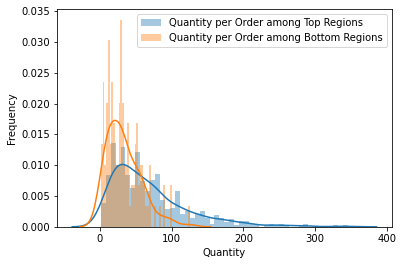

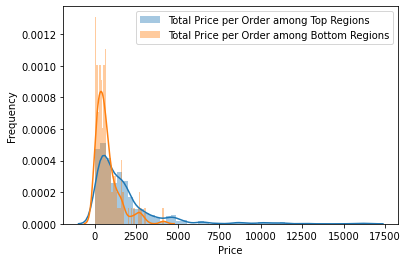

In [26]:
sns.distplot(df_top.Total_Quantity, bins = 50, label = 'Quantity per Order among Top Regions')
sns.distplot(df_bottom.Total_Quantity, bins = 50, label = 'Quantity per Order among Bottom Regions')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.legend()
plt.show()
sns.distplot(df_top.Total_Price, bins = 50, label = 'Total Price per Order among Top Regions')
sns.distplot(df_bottom.Total_Price, bins = 50, label = 'Total Price per Order among Bottom Regions')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [27]:
ks_test(df_top.Total_Quantity)
ks_test(df_bottom.Total_Quantity)
ks_test(df_top.Total_Price)
ks_test(df_bottom.Total_Price)

The data is not normally distributed
The data is not normally distributed
The data is not normally distributed
The data is not normally distributed


Based on the distributions and K-S plots, it seems as the samples are not normally distributed. Thus to decide which test to use, let's assess the sample size of the top and bottom regions.

In [28]:
print('Sample Size of Top Regions: {}'.format(len(df_top)))
print('Sample Size of Bottom Regions: {}'.format(len(df_bottom)))

Sample Size of Top Regions: 606
Sample Size of Bottom Regions: 120


In [29]:
stats.levene(df_top.Total_Quantity, df_bottom.Total_Quantity, center='mean')

LeveneResult(statistic=43.743134396316385, pvalue=7.275638215832466e-11)

As one can the sample sizes of the two datasets are quite different but over 30. Since we created the criteria to separate the data, one reevaluate the criteria that seperated the data in order to use statistical tests that require the sample sizes to be equal. However, this defeats the purpose of this analysis as the groups were decided on the  total price of orders and thus the samples cannot be altered. Furthermore, one can apply a Welch T-test because of the different sample sizes and evaluate if there is a significant difference in total price between the top and bottom region. 

In [30]:
print(welch_t_p_value(df_top.Total_Quantity.values, df_bottom.Total_Quantity.values, two_sided = True))
print(welch_t_p_value(df_top.Total_Price, df_bottom.Total_Price, two_sided = True))


0.0
0.0


This result helps to fully reject the null hypothesis that regions do not have a statistically significant effect on the price and quantity ordered as the regions were separated based on top and bottom regions and the two samples were then analyzed. Although the result t-value of 0 is usually unlikely, based on the criteria of the samples this makes sense as we already learned before that region does have a statistically significant affect on price and quantity ordered. Thus, let's now analyze the average order price and order quantity by region to find out how we can provide insight to the stakeholders. 

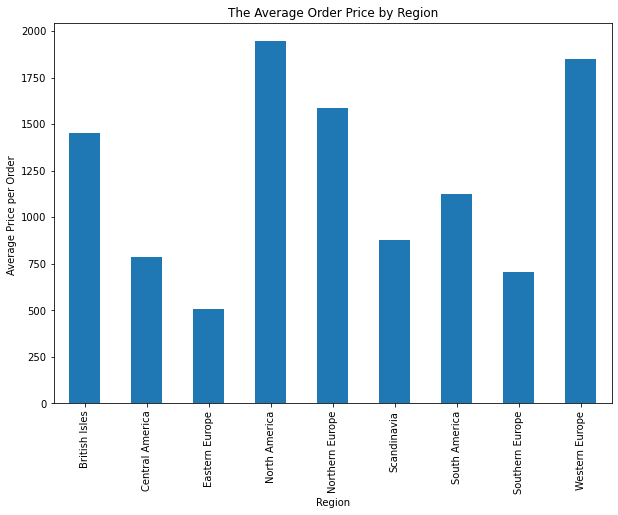

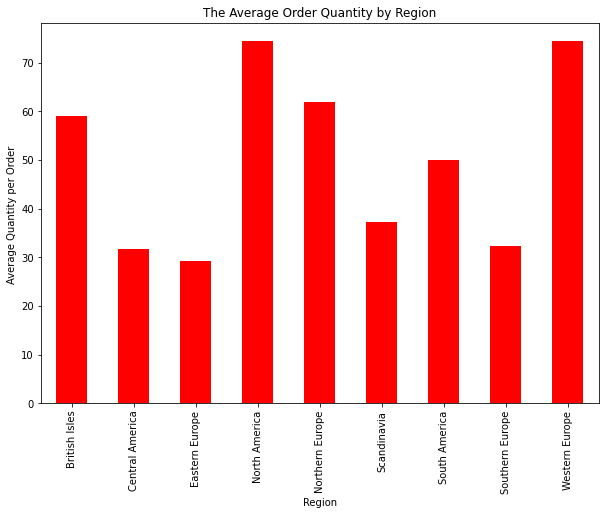

In [29]:
df_avg = df_reg.groupby(['Region']).mean()
df_avg.Total_Price.plot.bar(figsize = (10,7), title = 'The Average Order Price by Region')
plt.xlabel('Region')
plt.ylabel('Average Price per Order ')
plt.show()
df_avg.Total_Quantity.plot.bar(figsize = (10,7), title = 'The Average Order Quantity by Region', color = 'r')
plt.xlabel('Region')
plt.ylabel('Average Quantity per Order ')
plt.show()

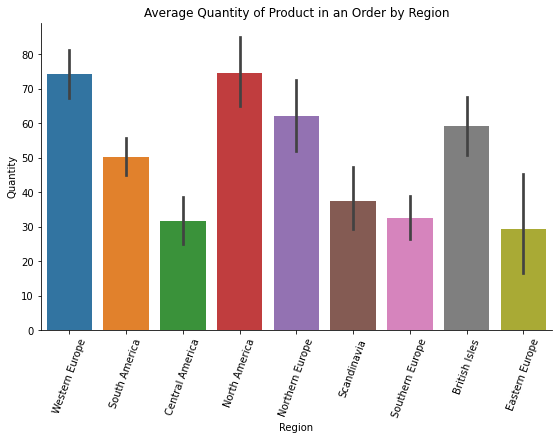

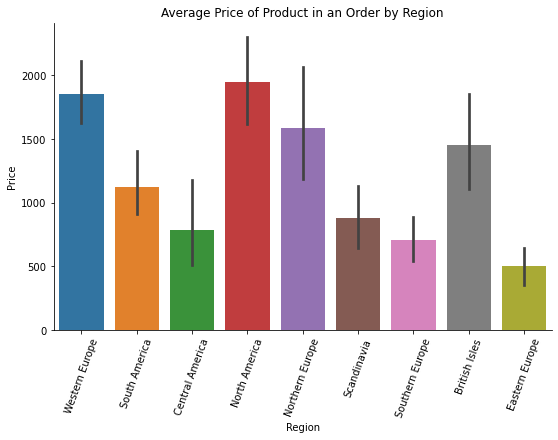

In [57]:
sns.catplot(x = 'Region', y = 'Total_Quantity', kind = 'bar', data = df_reg,height=5, aspect=1.6)
plt.xticks(rotation=70)
plt.ylabel('Quantity')
plt.title('Average Quantity of Product in an Order by Region')
plt.savefig('q2_quan.jpg', bbox_inches='tight')
plt.show()
sns.catplot(x = 'Region', y = 'Total_Price', kind = 'bar', data = df_reg,height=5, aspect=1.6)
plt.xticks(rotation=70)
plt.ylabel('Price')
plt.title('Average Price of Product in an Order by Region')
plt.savefig('q2_price.jpg', bbox_inches='tight')
plt.show()

The conclusions gained from the statistical significance of region's effect on price and quantity order combined with the figures above indicate that the bottom regions need more effort in working to increase the price and quantity ordered as their averages are lower and this difference is proven to be statistically significant. One way to address this problem could be finding out how products are being shipped to them. That is in fact our next hypothesis!

### Question 3: Does the shipping company have a significant difference on the total price of an order?

The hypotheses for this question are as follows: 

- $H_{o}$: Shipping company has no statistically significant effect on the price of a product in an order
- $H_{a}$: Shipping company has a statistically significant effect on the price of a product in an order

For now we will set $\alpha = 0.05$. Now we get to test this hypothesis! To do this let's first extract the total_price per order and the respective shipping company for said order. 

In [30]:
df_ship = pd.read_sql_query("""SELECT Shipper.CompanyName as Shipper, SUM(Quantity * UnitPrice * (1 - Discount)) AS Total_price FROM Orderdetail
                        JOIN [Order] ON OrderDetail.OrderID = [ORDER].ID 
                        JOIN Shipper ON [Order].ShipVia = Shipper.ID
                        GROUP BY OrderId;""", conn)
df_ship

,Shipper,Total_price
0,Federal Shipping,440.0000
1,Speedy Express,1863.4000
2,United Package,1552.6000
3,Speedy Express,654.0600
4,United Package,3597.9000
...,...,...
825,United Package,300.0000
826,United Package,232.0850
827,United Package,498.1000
828,United Package,792.7500


Now, lets split the dataset by shipping company and then analyze it's normality in order to see which type of test will be a good candidate for this question.

In [31]:
df_united = df_ship[df_ship.Shipper == 'United Package']
df_federal = df_ship[df_ship.Shipper == 'Federal Shipping']
df_speedy = df_ship[df_ship.Shipper == 'Speedy Express']

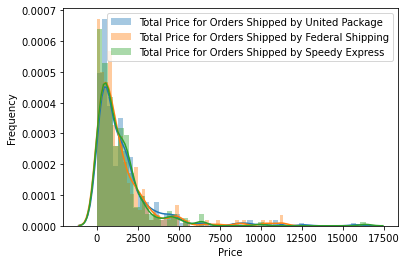

In [32]:
sns.distplot(df_united.Total_price, bins = 50, label = 'Total Price for Orders Shipped by United Package')
sns.distplot(df_federal.Total_price, bins = 50, label = 'Total Price for Orders Shipped by Federal Shipping')
sns.distplot(df_speedy.Total_price, bins = 50, label = 'Total Price for Orders Shipped by Speedy Express')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [33]:
ks_test(df_united.Total_price)
ks_test(df_federal.Total_price)
ks_test(df_speedy.Total_price)

The data is not normally distributed
The data is not normally distributed
The data is not normally distributed


As we can see from the distribution and K-S test results, the datasets are not normally distributed. Let's next analyze the variance and sample sizes so that we can decide on a test to use for hypothesis testing.

In [34]:
print(df_united.Total_price.var())
print(df_federal.Total_price.var())
print(df_speedy.Total_price.var())
print(df_ship.Shipper.value_counts())


3977500.8627873664
3368834.148274277
2685884.9520199215
United Package      326
Federal Shipping    255
Speedy Express      249
Name: Shipper, dtype: int64


Based off the information we have gained and the fact that there will be multiple comparisons made, ANOVA will be used to test this hypothesis. Thus, the threshold for this specific test is $\alpha = 0.01667$

In [35]:
formula = 'Total_price ~ C(Shipper)'
lm = ols(formula, df_ship).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq     df        F    PR(>F)
C(Shipper)  8.011953e+06    2.0  1.17711  0.308684
Residual    2.814471e+09  827.0      NaN       NaN


From these results, we cannot reject the null hypothesis and thus will do further testing among the 3 sets of data to see if there is a statistically significant effect on a shipping company's effect on the total price of an order via a Welch T-test where only two out of the three samples are compared at a time. 

In [36]:
print(welch_t_p_value(df_united.Total_price, df_federal.Total_price.values, two_sided = True))
print(welch_t_p_value(df_united.Total_price, df_speedy.Total_price.values, two_sided = True))
print(welch_t_p_value(df_federal.Total_price, df_speedy.Total_price.values, two_sided = True))

0.4041076207916734
0.12062416876466298
0.5081313201706394


Based of the results seen above we cannot reject the null hypothesis that shipping company has no statistically significant effect on the price of an order. 

### Question 4: Do specific categories have a higher average price? If so, is this difference statistically significant to conclude that categories have a statistically significant effect on average price of an order?

Let's once again define our null and alternative hypothesis:

- $H_{o}$: The average price per order is not different across different categories indicating category has no statistically significant effect on the average price of an order.
- $H_{o}$: The average price per order is different across different categories indicating category has no statistically significant effect on the average price of an order.

The threshold for rejecting the null hypothesis will be $\alpha = 0.05$ but this is subject to change depending on how many comparisons we will make. Let's next create the proper dataset to test this hypothesis.

In [59]:
df_cat = pd.read_sql_query("""SELECT CategoryName as Category, SUM(Quantity * Orderdetail.UnitPrice * (1 - Discount)) AS Total_price FROM Orderdetail
                    JOIN Product ON Orderdetail.Productid = product.id
                    JOIN Category ON Product.Categoryid = Category.id
                    GROUP BY OrderID""",conn)
df_cat

,Category,Total_price
0,Dairy Products,440.0000
1,Produce,1863.4000
2,Seafood,1552.6000
3,Grains/Cereals,654.0600
4,Confections,3597.9000
...,...,...
825,Dairy Products,300.0000
826,Confections,232.0850
827,Beverages,498.1000
828,Condiments,792.7500


Now let's analyze the average price per order by category by grouping the data based on category then calculating the average price per order.

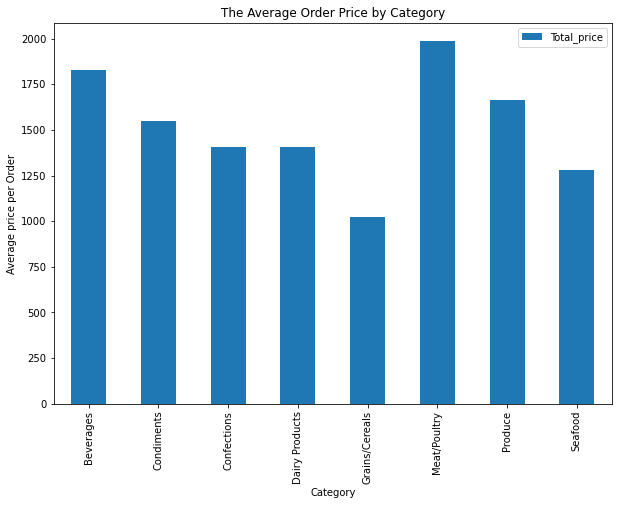

In [60]:
df_cat.groupby('Category').mean().plot.bar(figsize = (10,7), title = 'The Average Order Price by Category')
plt.ylabel('Average price per Order')
plt.show()

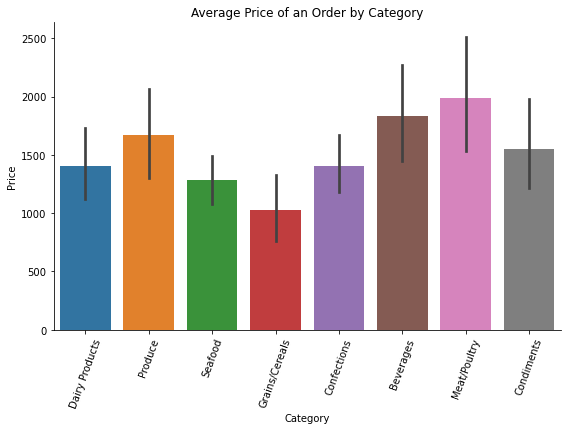

In [61]:
sns.catplot(x = 'Category', y = 'Total_price', kind = 'bar', data = df_cat,height=5, aspect=1.6)
plt.xticks(rotation=70)
plt.ylabel('Price')
plt.title('Average Price of an Order by Category')
plt.savefig('q4_price.jpg',bbox_inches='tight')
plt.show()

As we can see the average price per order by categories are not equal and thus a difference does exist between them. Based on the fact that multiple comparisons will be made in this test, the Bonferroni correction needs to be applied where $\alpha_{new} = \frac{\alpha_{current}}{n}$ where n is the number of samples being compared and thus in this case with the number of categories being n, $\alpha_{new} = 0.00625$

In [53]:
formula = 'Total_price ~ C(Category)'
lm = ols(formula, df_cat).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                   sum_sq     df         F    PR(>F)
C(Category)  5.482300e+07    7.0  2.326076  0.023588
Residual     2.767660e+09  822.0       NaN       NaN


Based off these test results, the null hypothesis cannot be rejected and thus we can for the time being conclude that categories do not have a statistically significant effect on a price of an order. 

# Conclusion

Based of the results gained from performing hypotheses tests, the following recommendations would be given to stakeholders:

1. Discounts do lead to a significant difference in quantity of a product order and thus more items should be discounted at 15% and 25% as it was found that these 2 discount groups have the largest effect. 

2. More effort needs to be put in regions where the average price per order is lower as this difference was proven to be significant and thus there is low-hanging fruit in working to increase the average price in these regions. These regions include: 

    - Eastern Europe
    - Southern Europe
    - Scandinavia
    - Central America

3. Although it might be against conventional wisdom, the shipping company does not have a significant effect on the average price of an order, and thus no focus should be put on using one shipping company over the other. 

4. Categories of products within an order have no significant effect on the average price of an order and therefore all categories should have equal focus as the tests within this study cannot prove that additional focus will lead to a statistically significant increase in price of an order. 

